In [1]:
!pip install sentence_transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 KB 7.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 64.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 58.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 25.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 44.6 MB/s eta 0:00:00
  Created wheel for sentence_transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125942 sha256=1a30a8e96776ad911c97c9ac0884204515d5a602beb321acab203bb1be63fe2a
  Stored in directory: /root/.cache/pip/wheels/71/67/06/162a3760c40d74dd40bc855d527008d26341c2b0ecf3e8e11f
Successfully built sentence_transformers


In [38]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import re
from sklearn.model_selection import train_test_split
import torch
from sklearn.metrics import accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from sentence_transformers import SentenceTransformer, InputExample, losses, models, datasets, evaluation
from torch.utils.data import DataLoader
from torch import nn
from sklearn.utils.class_weight import compute_class_weight
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from matplotlib.pyplot import figure

In [3]:
np.random.seed(42)

In [5]:
#Read the Data

df_main = pd.read_csv('./classification_data.csv')
df_main.head()

,title,label
0,"Director, Learning and Support",CLASS1
1,Customer Service Assistant,CLASS2
2,2023 Internship and Education Program Manageme...,CLASS13
3,Communications Technician,CLASS13
4,Emergency Preparedness Officer,CLASS3


In [6]:
""" Data Pre-processing and Visualization  """ 

# check for null values

assert df_main.isnull().values.any() == False

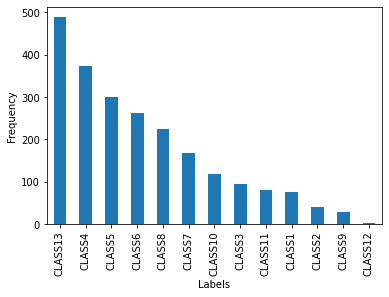

In [7]:
#class-wise distribution of data
fig, ax = plt.subplots()
df_main['label'].value_counts().plot(ax=ax, kind='bar')

ax.set_ylabel("Frequency")
ax.set_xlabel("Labels")
plt.show()

In [8]:
df_main['label'].value_counts()

CLASS13    489
CLASS4     373
CLASS5     300
CLASS6     263
CLASS8     225
CLASS7     168
CLASS10    119
CLASS3      94
CLASS11     81
CLASS1      76
CLASS2      40
CLASS9      28
CLASS12      3
Name: label, dtype: int64

In [9]:
# Remove non-encoding token, remove unnecessary tokens like -, comma, /,\ etc. numbers like 2023 and (1101l), lowercase the text
# can remove stop words like 'and', 'for' but not required!!


def pre_process(df_main,df_processed):
    df_processed['title'] = df_main['title'].apply(lambda x : re.sub(r'[^A-Za-z ]+', '', x))
    df_processed['title'] = df_processed['title'].apply(lambda x : " ".join(x.split()))
    df_processed['title'] = df_processed['title'].apply(lambda x : x.lower())
    df_processed['label'] = df_main['label'].apply(lambda x : int(x[5:]) )
    return df_processed

df_processed = pd.DataFrame()
df_processed = pre_process(df_main,df_processed)



In [10]:
df_processed

,title,label
0,director learning and support,1
1,customer service assistant,2
2,internship and education program management in...,13
3,communications technician,13
4,emergency preparedness officer,3
...,...,...
2254,team lead qa all genders,8
2255,associate director gra qms quality,8
2256,continuous improvement champion ii,4
2257,manager global evidence and outcomes china sha...,13


In [11]:
def split_dataset(df_processed):
    
    df_class12 = df_processed[df_processed['label'] == 12]
    class12_index = df_class12.index
    
    df_processed = df_processed.drop(df_class12.index)
    
    X_train, X_test_temp , y_train, y_test_temp = train_test_split(df_processed['title'], df_processed['label'],
                                                    stratify=df_processed['label'], shuffle= True,
                                                    test_size=0.3)
    
    X_test, X_valid, y_test, y_valid = train_test_split(X_test_temp, y_test_temp,
                                                    stratify=y_test_temp, shuffle= True,
                                                    test_size=0.5)
    
    # handle the most underpresented class ---> class 12
    
    X_train = X_train.append(df_class12['title'][:2])
    y_train = y_train.append(df_class12['label'][:2])
    
    X_test = X_test.append(df_class12['title'][1:2])
    y_test = y_test.append(df_class12['label'][1:2])
    
    X_valid = X_valid.append(df_class12['title'][2:3])
    y_valid = y_valid.append(df_class12['label'][2:3])
    
    return X_train, X_test, X_valid , y_train, y_test, y_valid
    
    
X_train, X_test, X_valid, y_train, y_test, y_valid = split_dataset(df_processed)


<ipython-input-11-ab94d2c1a479>:18: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_class12['title'][:2])
<ipython-input-11-ab94d2c1a479>:19: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(df_class12['label'][:2])
<ipython-input-11-ab94d2c1a479>:21: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_test = X_test.append(df_class12['title'][1:2])
<ipython-input-11-ab94d2c1a479>:22: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_test = y_test.append(df_class12['label'][1:2])
<ipython-input-11-ab94d2c1a479>:24: FutureWarning: The series.append method is deprecated and will be removed from

In [13]:
def sentence_pairs_generation(sentences, labels, pairs):

  numClassesList = np.unique(labels)
  # print(numClassesList)
  idx = [np.where(labels == i)[0] for i in numClassesList]
  # print(idx)
  for k in range(10):
    for idxA in range(len(sentences)):      
      currentSentence = sentences[idxA]
      label = labels[idxA]
      idxB = np.random.choice(idx[np.where(numClassesList==label)[0][0]])
      posSentence = sentences[idxB]
        # prepare a positive pair and update the sentences and labels
      pairs.append(InputExample(texts=[currentSentence, posSentence], label=int(label)-1))
    
  return (pairs)

In [14]:
# # compute class weights
# class_wts = compute_class_weight('balanced', np.unique(train_labels), train_labels)

# # convert class weights to tensor
# weights= torch.tensor(class_wts,dtype=torch.float)
# weights = weights.to(device)

# # loss function
# cross_entropy  = nn.NLLLoss(weight=weights) 


In [15]:

train_examples = []

train_examples = sentence_pairs_generation(np.array(X_train), np.array(y_train), train_examples)

word_embedding_model = models.Transformer('bert-base-uncased', max_seq_length=256)
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension())
dense_model = models.Dense(in_features=pooling_model.get_sentence_embedding_dimension(), out_features=256, activation_function=nn.Tanh())

model = SentenceTransformer(modules=[word_embedding_model, pooling_model, dense_model])

train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=16)


train_loss = losses.SoftmaxLoss(model=model, sentence_embedding_dimension=256, num_labels=13)

model.fit(train_objectives=[(train_dataloader, train_loss)], epochs=5, warmup_steps=10, show_progress_bar=True)



Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration:   0%|          | 0/989 [00:00<?, ?it/s]

Iteration:   0%|          | 0/989 [00:00<?, ?it/s]

Iteration:   0%|          | 0/989 [00:00<?, ?it/s]

Iteration:   0%|          | 0/989 [00:00<?, ?it/s]

Iteration:   0%|          | 0/989 [00:00<?, ?it/s]

In [21]:
#build a classifier on the sentence embeddings
X_train_encode = model.encode(np.array(X_train))

X_eval = model.encode(np.array(X_valid))

# balance is making confusion materix good. But overall accuracy goes down
svm =  SVC(kernel = 'rbf',class_weight = 'balanced')
svm.fit(X_train_encode, y_train)
y_pred_eval = svm.predict(X_eval)

print('Acc. Score', accuracy_score(y_valid, y_pred_eval))
# balance is making confusion materix good. But overall accuracy goes down


Acc. SetFit 0.6676470588235294


In [26]:
# test accuracy
X_test = model.encode(np.array(X_test))
y_pred_test = svm.predict(X_test)

print('Acc. Score', accuracy_score(y_test, y_pred_test))

Acc. Score 0.6755162241887905


In [33]:
#classwise F1 score
f1_score(y_test, y_pred_test, average=None)

array([0.75      , 0.8       , 0.68965517, 0.60194175, 0.67391304,
       0.76315789, 0.58333333, 0.59459459, 0.88888889, 0.83333333,
       0.3       , 1.        , 0.72      ])

In [30]:
#confusion matrix
cf_matrix=confusion_matrix(y_test, y_pred_test)
cf_matrix

array([[ 9,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  3],
       [ 0,  6,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 10,  0,  0,  0,  0,  0,  1,  1,  0,  0,  2],
       [ 0,  0,  1, 31, 11,  0,  1,  6,  0,  0,  1,  0,  5],
       [ 0,  0,  2,  5, 31,  1,  0,  4,  0,  0,  1,  0,  1],
       [ 2,  0,  0,  2,  1, 29,  0,  1,  0,  2,  0,  0,  2],
       [ 0,  1,  1,  0,  2,  0, 14,  1,  0,  0,  0,  0,  6],
       [ 0,  0,  0,  5,  1,  1,  4, 22,  0,  0,  1,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  4,  0,  0,  0,  0],
       [ 0,  0,  1,  0,  0,  1,  0,  0,  0, 15,  0,  0,  1],
       [ 0,  1,  0,  1,  1,  0,  0,  3,  0,  0,  3,  0,  3],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0],
       [ 1,  1,  0,  3,  0,  5,  4,  3,  0,  0,  2,  0, 54]])

<Axes: >

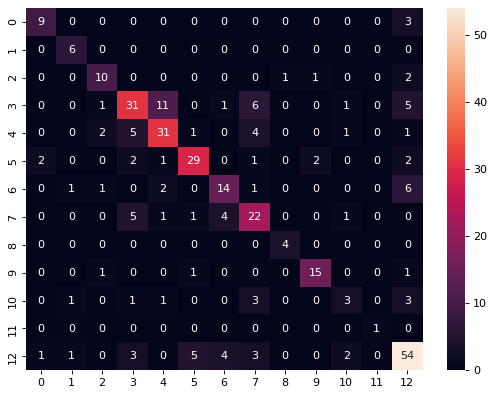

In [40]:
figure(figsize=(8, 6), dpi=80)
sns.heatmap(cf_matrix, annot=True)

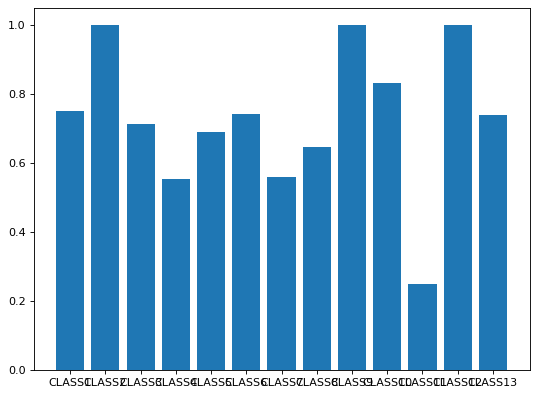

In [37]:
#classwise accuracy
class_acc = cf_matrix.diagonal()/cf_matrix.sum(axis=1)

class_label = ['CLASS'+str(i+1) for i in range(13)]

figure(figsize=(8, 6), dpi=80)
plt.bar(class_label,class_acc)
plt.show()

In [32]:
classification_report(y_test, y_pred_test)

'              precision    recall  f1-score   support\n\n           1       0.75      0.75      0.75        12\n           2       0.67      1.00      0.80         6\n           3       0.67      0.71      0.69        14\n           4       0.66      0.55      0.60        56\n           5       0.66      0.69      0.67        45\n           6       0.78      0.74      0.76        39\n           7       0.61      0.56      0.58        25\n           8       0.55      0.65      0.59        34\n           9       0.80      1.00      0.89         4\n          10       0.83      0.83      0.83        18\n          11       0.38      0.25      0.30        12\n          12       1.00      1.00      1.00         1\n          13       0.70      0.74      0.72        73\n\n    accuracy                           0.68       339\n   macro avg       0.70      0.73      0.71       339\nweighted avg       0.67      0.68      0.67       339\n'